#### Notebook to examine the observational data 

This is notebook is used to examine observational data and come back to it to understand what steps are being taken

#### Tide gauge data

In [30]:
import pandas as pd
import numpy as np


# Define stations
stations = ['Vlissingen', 'Hoek v. Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden', 'Average']



# Define paths to data
path_tg = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/SLH/rlr_annual'
path_locations = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/SLH/rlr_annual/filelist.txt'
    
# Import tide gauge sea level data
loc_num = [20, 22, 23, 24, 25, 32]
col_names = ['id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality']
filelist_df = pd.read_csv(path_locations, sep=';', header=None, names=col_names)
filelist_df = filelist_df.set_index('id')
filelist_df = filelist_df.loc[loc_num, :]
names_col = ('time', 'height', 'interpolated', 'flags')
    
for i in range(len(loc_num)):
        tg_data = pd.read_csv(path_tg + '/data/' + str(loc_num[i]) + 
                              '.rlrdata', sep=';', header=None, names=names_col)
        tg_data = tg_data.drop(['interpolated', 'flags'], 1)
        tg_data = tg_data.set_index('time')

        if i==0:
            tg_data_df = pd.DataFrame(data=dict(time=tg_data.index, col_name=tg_data.height))
            tg_data_df = tg_data_df.set_index('time')
            tg_data_df.columns  = [str(loc_num[i])] 
        else:
            tg_data_df[str(loc_num[i])] = tg_data.height
            

tg_data_df = tg_data_df.rename(columns={"20": stations[0],
                                        "22": stations[1], "23": stations[2],
                                        "24": stations[3], "25": stations[4],
                                        "32": stations[5]})


    

<AxesSubplot:xlabel='time', ylabel='Sea level height [mm]'>

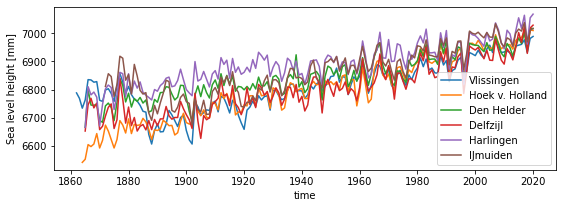

In [31]:
tg_data_df.plot(figsize=(9,3), ylabel = 'Sea level height [mm]')

The time series start in 1862 (Vlissingen), 1864 (Hoek v. Holland), 1865 (Den Helder, Delfzijl, Harlingen) and 1872 (IJmuiden). All time series (except maybe Hoek v. Holland) show weird results before 1890 so the data is used starting from 1890. 

The time series are till 2020. 


The data is between 6 and 7m but anomalies are obtained using the mean from 1890 till 2020


In [40]:
for i in range(len(loc_num)):
        tg_data = pd.read_csv(path_tg + '/data/' + str(loc_num[i]) + 
                              '.rlrdata', sep=';', header=None, names=names_col)
        tg_data = tg_data.drop(['interpolated', 'flags'], 1)
        tg_data = tg_data.set_index('time')
        
        # Data before 1890 is incorrect
        tg_data = tg_data[tg_data.index>=1890] 

        tg_data.height = tg_data.height - tg_data.height.mean() # Calculate anomality over whole period

        if i==0:
            tg_data_df = pd.DataFrame(data=dict(time=tg_data.index, col_name=tg_data.height))
            tg_data_df = tg_data_df.set_index('time')
            tg_data_df.columns  = [str(loc_num[i])] 
        else:
            tg_data_df[str(loc_num[i])] = tg_data.height
            

tg_data_df = tg_data_df.rename(columns={"20": stations[0],
                                        "22": stations[1], "23": stations[2],
                                        "24": stations[3], "25": stations[4],
                                        "32": stations[5]})

tg_data_df = tg_data_df*0.1 # mm -> cm

<AxesSubplot:xlabel='time', ylabel='Sea level height anomalies [cm]'>

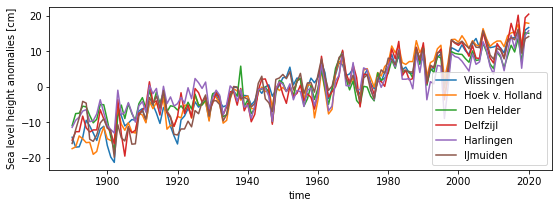

In [41]:
tg_data_df.plot(figsize=(9,3), ylabel = 'Sea level height anomalies [cm]')

The anomalies of mean sea level for the Dutch coast are between -20 and 20 cm

<AxesSubplot:title={'center':'Average of tide gauge stations'}, xlabel='time', ylabel='Sea level height anomalies [cm]'>

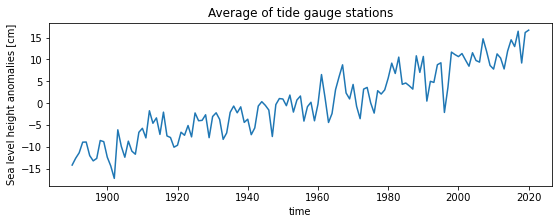

In [42]:
tg_data_df['Average'] = tg_data_df.mean(axis=1) # Add column containing the average of the stations 

tg_data_df['Average'].plot(figsize = (9,3), ylabel = 'Sea level height anomalies [cm]', title='Average of tide gauge stations')

In [43]:
tg_data_df.isnull().values.any() # Check if there are nan values

False

Interpolation is unnecessary

tg_data_df = tg_data_df.interpolate(method='slinear') # Interpolation to fill nan values

#### Wind data

##### ERA5

In [45]:
import xarray as xr

# Define the paths to code which comes from two different dataproducts
path_fp = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/Wind/wind_era5_fp.nc' #1950 - 1978
path_sp = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/Wind/wind_era5_sp.nc' #1979 - present


# Open data file
data_fp = xr.open_dataset(path_fp) #1950 - 1978
data_sp = xr.open_dataset(path_sp) #1979 - present


# Add the two datasets
dataset = xr.concat([data_fp, data_sp], dim='time')


# Data also contains variable expver = 5 but this has nan values except for last two months (2021) 
dataset = dataset.drop('expver')
dataset = dataset.sel(expver=0,drop=True)

        
# Change coordinate and variable names
dataset = dataset.rename({'longitude': 'lon','latitude': 'lat', 'u10' : 'u', 'v10' : 'v'})


# Sort longitudes increasing
dataset = dataset.sortby('lon')


# Select smaller area of data 
dataset = dataset.where((dataset.lat > 40) & (dataset.lat < 90) & (dataset.lon > -40) & (dataset.lon < 30), drop=True)


# Obtain stress for monthly averaged data (wind is squared, sign is retained)
dataset = dataset.assign(u2 = dataset.u**2*np.sign(dataset.u))
dataset = dataset.assign(v2 = dataset.v**2*np.sign(dataset.v))  


# Calculate annual averages 
dataset_annual = dataset.groupby('time.year').mean('time')


# Remove 2021 
dataset_annual = dataset_annual.where(dataset_annual.year <2021, drop=True)   

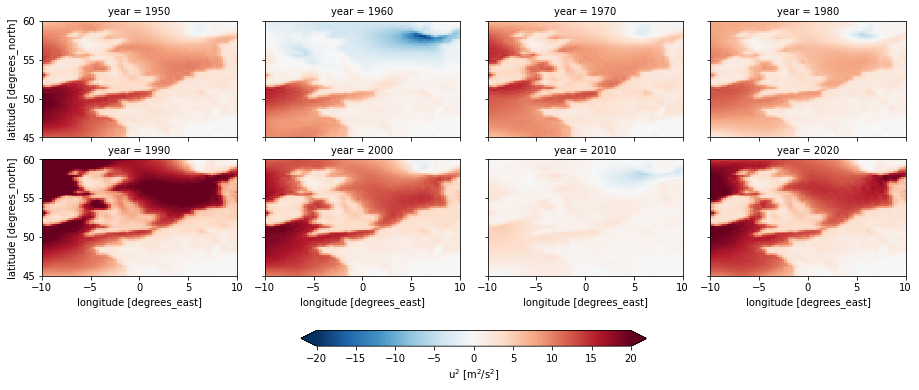

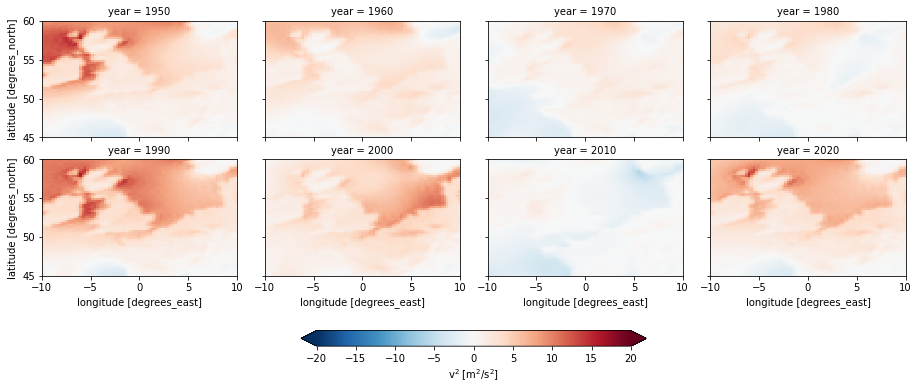

In [109]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Plot for eachs start of the decade (decadal averages would be better)
decades = range(1950, 2021, 10)
dataset_decadal = dataset_annual.sel(year = decades, drop=True)

dataset_decadal.u2.plot(col='year', col_wrap=4, vmin=-20, xlim= [-10,10], ylim= [45,60], cbar_kwargs={"orientation": "horizontal", "shrink": 0.4, 
                                                            "label": "u$^2$ [m$^2$/s$^2$]"})

dataset_decadal.v2.plot(col='year', col_wrap=4, vmin=-20, xlim= [-10,10], ylim= [45,60], cbar_kwargs={"orientation": "horizontal", "shrink": 0.4, 
                                                            "label": "v$^2$ [m$^2$/s$^2$]"})

##### 20CRv3

In [111]:
# Define the path to code
path_u = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/Wind/wind_20cr_u.nc' # Path to zonal wind
path_v = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/Wind/wind_20cr_v.nc' # Path to meridional wind


# Open data file
u = xr.open_dataset(path_u) 
v = xr.open_dataset(path_v) 


# Add the two datasets
dataset = u.assign(vwnd = v.vwnd)


# Shift longitudes from 0 - 360 to -180 to 180
longitudes_list = np.concatenate([np.arange(0, 180), np.arange(-180, 0)])
dataset = dataset.assign_coords(lon = longitudes_list)


# Sort longitudes increasing
dataset = dataset.sortby('lon')


# Change coordinate and variable names
dataset = dataset.rename({'uwnd' : 'u', 'vwnd' : 'v'})
    
    
#Drop 'time_bnds' variables
dataset = dataset.drop('time_bnds')


# Select smaller area of data 
dataset = dataset.where((dataset.lat > 40) & (dataset.lat < 90) & (dataset.lon > -40) & (dataset.lon < 30), drop=True)


# Obtain stress for monthly averaged data (wind is squared, sign is retained)
dataset = dataset.assign(u2 = dataset.u**2*np.sign(dataset.u))
dataset = dataset.assign(v2 = dataset.v**2*np.sign(dataset.v))  


# Calculate annual averages 
dataset_annual = dataset.groupby('time.year').mean('time')


# Remove 2021 
dataset_annual = dataset_annual.where(dataset_annual.year <2021, drop=True)          



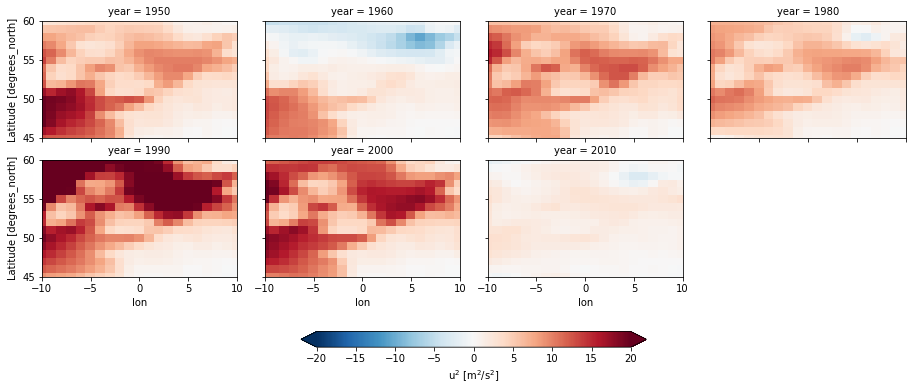

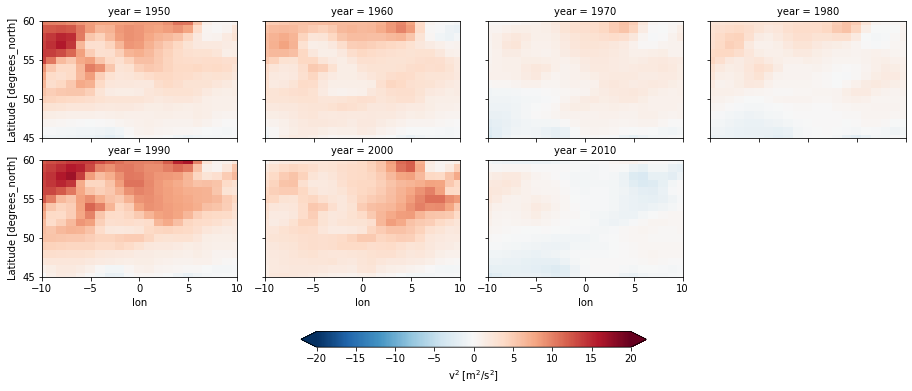

In [113]:
# Plot for eachs start of the decade (decadal averages would be better)
decades = range(1950, 2011, 10)
dataset_decadal = dataset_annual.sel(year = decades, drop=True)

dataset_decadal.u2.plot(col='year', col_wrap=4, vmin=-20, xlim= [-10,10], ylim= [45,60], cbar_kwargs={"orientation": "horizontal", "shrink": 0.4, 
                                                            "label": "u$^2$ [m$^2$/s$^2$]"})

dataset_decadal.v2.plot(col='year', col_wrap=4, vmin=-20, xlim= [-10,10], ylim= [45,60], cbar_kwargs={"orientation": "horizontal", "shrink": 0.4, 
                                                            "label": "v$^2$ [m$^2$/s$^2$]"})

As can be seen the 20CR data has a lower spatial resolution than the ERA5 data.


#### Pressure data

##### ERA5

In [116]:
# Define the path to code
path_fp = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/Pressure/pres_era5_fp.nc' # Path to surface pressure 1950-1978
path_sp = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/Pressure/pres_era5_sp.nc' # Path to surface pressure 1979-present
        

# Open data file
dataset_fp = xr.open_dataset(path_fp)
dataset_sp = xr.open_dataset(path_sp) 
        
        
# Add the two datasets
dataset = xr.concat([dataset_fp, dataset_sp], dim='time')


# Change coordinate and variable names
dataset = dataset.rename({'longitude': 'lon','latitude': 'lat','msl': 'pressure'})


# Sort latitudes increasing
dataset = dataset.sortby('lat')


# Calculate annual averages 
dataset_annual = dataset.groupby('time.year').mean('time')

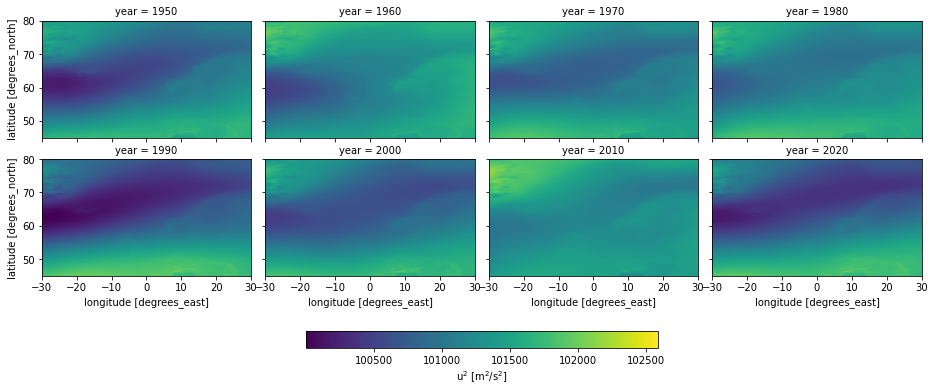

In [118]:
decades = range(1950, 2021, 10)
dataset_decadal = dataset_annual.sel(year = decades, drop=True)

dataset_decadal.pressure.plot(col='year', col_wrap=4, xlim= [-30,30], ylim= [45,80], cbar_kwargs={"orientation": "horizontal", "shrink": 0.4, 
                                                            "label": "u$^2$ [m$^2$/s$^2$]"})

##### 20CRv3

In [119]:
# Define the path to code
path = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/Pressure/prmsl.mon.mean.nc' # Path to zonal wind

        
# Open data file
dataset = xr.open_dataset(path) 

        
# Shift longitudes to -180-180 
dataset.coords['lon'] = (dataset.coords['lon'] + 180) % 360 - 180
dataset = dataset.sortby(dataset.lon)


# Change coordinate and variable names
dataset = dataset.rename({'prmsl': 'pressure'})
    
    
#Drop 'time_bnds' variables
dataset = dataset.drop('time_bnds')
        
        
# Select smaller area of data 
dataset = dataset.where((dataset.lat >= 0) & (dataset.lat <= 90) & (dataset.lon >= -90) & (dataset.lon <= 90), drop=True)


# Calculate annual averages 
dataset_annual = dataset.groupby('time.year').mean('time')